Install efficientnet for pytorch

In [1]:
!pip install efficientnet-pytorch

Import required libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from tempfile import TemporaryDirectory
import pandas as pd
import shutil
import random
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
import time
from datetime import datetime
import copy
from efficientnet_pytorch import EfficientNet
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

# use best algorithm for hardware
cudnn.benchmark = True

# interactive mode for graph plot
plt.ion()

# set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Extract data

In [ ]:
#copy data zip from drive
from google.colab import drive
drive.mount('/content/drive')
!cp drive/MyDrive/uni/Honours/ISIC_2019.zip ./ISIC_2019.zip

#unzip dataset
!unzip -x -q ISIC_2019.zip

#remove zip file
!rm ISIC_2019.zip

Mounted at /content/drive


Sort data into folders based on class

In [11]:
# function to sort the images into class folders based on given csv file
def copy_images_to_folders(csv_path, image_folder, output_folder):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_path)

    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        image_name = row['image'] + '.jpg'  # Assuming images have '.jpg' extension
        image_path = os.path.join(image_folder, image_name)

        # Iterate through class columns and copy images to the corresponding folders
        for class_name in df.columns[1:]:
            class_folder = os.path.join(output_folder, class_name)
            os.makedirs(class_folder, exist_ok=True)  # Create folder if it doesn't exist

            if row[class_name] == 1:  # Check if the image belongs to the class
                shutil.copy(image_path, class_folder)

csv_path = 'ISIC_2019_Training_GroundTruth.csv'
image_folder = 'ISIC_2019_Resized'
output_folder = 'ISIC_Sorted'

copy_images_to_folders(csv_path, image_folder, output_folder)

print("done")

done


Select random subset of data from every class for training and validation

In [28]:
# declare variables for model creation
input_folder = 'ISIC_Sorted'  # This is the folder containing class subdirectories
output_folder = 'data_subset'  # The desired output folder for "training" and "validation" folders
#data_dir = '/content/data_subset'
num_samples=12875
train_ratio=0.8
val_ratio=0.1
test_ratio=0.1

if train_ratio+val_ratio+test_ratio != 1:
    print("ratios not equal to 1")

set_batch_size=32

#sample numbers by class copied here for reference
#MEL	NV	  BCC	  AK	BKL	  DF	VASC	SCC	UNK
#4522	12875	3323	867	2624	239	253	  628	0

'''
Melanoma (MEL)
Melanocytic nevus (NV)
Basal cell carcinoma (BCC)
Actinic keratosis (AK)
Benign keratosis (BKL) [solar lentigo / seborrheic keratosis / lichen planus-like keratosis]
Dermatofibroma (DF)
Vascular lesion (VASC)
Squamous cell carcinoma (SCC)
None of the others (UNK)
'''

print("done")

done


In [27]:
# Remove existing "training" and "validation" folders if they exist
training_folder = os.path.join(output_folder, 'train')
validation_folder = os.path.join(output_folder, 'val')
test_folder = os.path.join(output_folder, 'test')

shutil.rmtree(training_folder, ignore_errors=True)
shutil.rmtree(validation_folder, ignore_errors=True)
shutil.rmtree(test_folder, ignore_errors=True)

# Create the "training" and "validation" folders
os.makedirs(training_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# generate list of class names from the folder structure
class_names = [class_name for class_name in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, class_name))]

print("done")

done


In [29]:
# Iterate through each class folder
for class_name in os.listdir(input_folder):
    class_folder_input = os.path.join(input_folder, class_name)
    if os.path.isdir(class_folder_input):
        # Get a list of all images in the class folder
        images = [img for img in os.listdir(class_folder_input) if img.endswith('.jpg')]

        # Randomly shuffle the list of images
        np.random.seed(42)
        np.random.shuffle(images)

        #calculate size of class
        class_size = len(os.listdir(os.path.join(input_folder, class_name)))

        # Calculate the number of samples for training and validation
        num_training_samples = int(class_size * (train_ratio))
        num_val_samples = int(class_size * (val_ratio))
        num_test_samples = int(class_size * (test_ratio))

        # Create the class subfolders within the "training" and "validation" folders
        class_folder_training = os.path.join(training_folder, class_name)
        class_folder_validation = os.path.join(validation_folder, class_name)
        class_folder_test = os.path.join(test_folder, class_name)
        os.makedirs(class_folder_training, exist_ok=True)
        os.makedirs(class_folder_validation, exist_ok=True)
        os.makedirs(class_folder_test, exist_ok=True)

        # Copy images to the "training" folder
        for image_name in images[:num_training_samples]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_training)
        # Copy images to the "validation" folder
        for image_name in images[num_training_samples:num_training_samples + num_val_samples]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_validation)
        # Copy images to the "test" folder
        for image_name in images[num_training_samples + num_val_samples:class_size]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_test)

print("done")

done


In [30]:
#remove unknown folder as no samples
shutil.rmtree("data_subset/train/UNK", ignore_errors=True)
shutil.rmtree("data_subset/val/UNK", ignore_errors=True)
shutil.rmtree("data_subset/test/UNK", ignore_errors=True)

In [31]:
#transform data
data_transforms = {
'train': transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'test': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
}

In [32]:
# create datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(output_folder, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=set_batch_size, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

#print checks to see if the values are the same - if yes then can remove the assignment here
print(f"file: ", class_names)
class_names = image_datasets['train'].classes
print(f"file: ", class_names)

file:  ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'UNK', 'VASC']
file:  ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


In [33]:
# get the sample size for each class
class_sizes = [len(os.listdir(os.path.join(training_folder, class_name))) for class_name in class_names]

# get the max sample size across classes
max_class_size = max(class_sizes)

# Calculate the desired repetitions for each class
# this is the number of times a sample needs to be repeated to match the max class size
desired_repetitions = [max_class_size // class_size if class_size > 0 else 1 for class_size in class_sizes]

# Iterate through each class and oversample accordingly
for class_index, class_name in enumerate(class_names):
    #get the training folder for the current class
    class_folder_training = os.path.join(training_folder, class_name)
    class_indices = [i for i, label in enumerate(image_datasets['train'].targets) if label == class_index]

    weights = [1.0 if label != class_index else desired_repetitions[class_index] for label in image_datasets['train'].targets]
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

    # Update the data loader for the "training" set with the weighted sampler
    dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=set_batch_size, sampler=sampler, num_workers=2)

In [ ]:
# Duplicate validation dataset
image_datasets['val_oversampled'] = copy.deepcopy(image_datasets['val'])

# Create a dataloader for the oversampled validation dataset
val_oversampled_dataloader = torch.utils.data.DataLoader(image_datasets['val_oversampled'], batch_size=set_batch_size, shuffle=False, num_workers=2)

# Oversample the validation dataset
val_desired_repetitions = [max_class_size // class_size if class_size > 0 else 1 for class_size in class_sizes]

for class_index, class_name in enumerate(class_names):
    val_class_folder = os.path.join(output_folder, 'val', class_name)
    val_class_indices = [i for i, label in enumerate(image_datasets['val_oversampled'].targets) if label == class_index]

    val_weights = [1.0 if label != class_index else val_desired_repetitions[class_index] for label in image_datasets['val_oversampled'].targets]
    val_sampler = WeightedRandomSampler(val_weights, len(val_weights), replacement=True)

    # Update the sampler for the existing dataloader
    val_oversampled_dataloader = torch.utils.data.DataLoader(image_datasets['val_oversampled'], batch_size=set_batch_size, sampler=val_sampler, num_workers=2)

# Calculate the size of the oversampled validation dataset and add it to dataset_sizes
dataset_sizes['val_oversampled'] = len(image_datasets['val_oversampled'])

# Assign the final oversampled dataloader to the dictionary
dataloaders['val_oversampled'] = val_oversampled_dataloader

show sample images

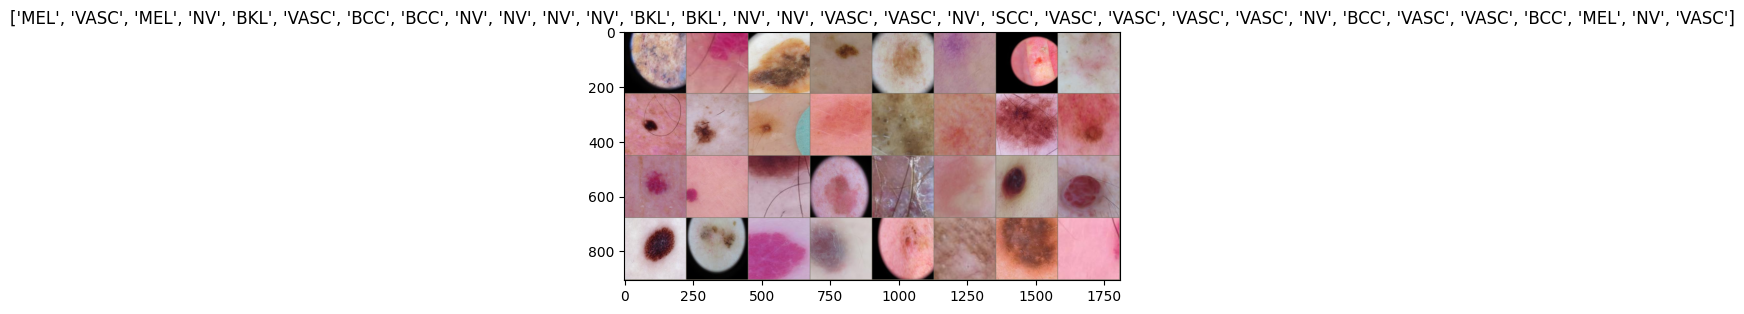

In [34]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

model training function

In [35]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            print(f'Epoch {epoch}/{num_epochs - 1} - {current_time}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                data_loader = dataloaders[phase]

                for inputs, labels in data_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == 'train':
                    print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
                elif phase == 'val':
                    print(f'Val Loss: {epoch_loss:.4f}, Val Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        torch.save(model.state_dict(), best_model_params_path)
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        model.load_state_dict(torch.load(best_model_params_path))

    return model

temporary fix for efficientnet weights issue

In [36]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model fitting configuration

In [37]:
class CustomEfficientNetB0(nn.Module):
    def __init__(self, num_classes=1, dropout_prob=0.5):
        super(CustomEfficientNetB0, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)
        num_ftrs = self.model._fc.in_features
        self.model._fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

# Initialize the model with dropout
model_ft = CustomEfficientNetB0(num_classes=len(class_names), dropout_prob=0.5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Use Adam optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b0


train model

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24 - 2024-02-06 21:32:34
----------
Train Loss: 0.8407, Train Acc: 0.7115
Val Loss: 0.9706, Val Acc: 0.6864

Epoch 1/24 - 2024-02-06 21:34:27
----------
Train Loss: 0.7398, Train Acc: 0.7405
Val Loss: 0.8697, Val Acc: 0.6813

Epoch 2/24 - 2024-02-06 21:36:16
----------
Train Loss: 0.6901, Train Acc: 0.7592
Val Loss: 0.8001, Val Acc: 0.7058

Epoch 3/24 - 2024-02-06 21:38:05
----------
Train Loss: 0.6828, Train Acc: 0.7580
Val Loss: 0.8886, Val Acc: 0.7070

Epoch 4/24 - 2024-02-06 21:39:54
----------
Train Loss: 0.6397, Train Acc: 0.7738
Val Loss: 0.8976, Val Acc: 0.6932

Epoch 5/24 - 2024-02-06 21:41:43
----------
Train Loss: 0.6197, Train Acc: 0.7793
Val Loss: 0.8221, Val Acc: 0.7193

Epoch 6/24 - 2024-02-06 21:43:31
----------
Train Loss: 0.6015, Train Acc: 0.7861
Val Loss: 0.8015, Val Acc: 0.7200

Epoch 7/24 - 2024-02-06 21:45:20
----------
Train Loss: 0.5205, Train Acc: 0.8137
Val Loss: 0.6423, Val Acc: 0.7663

Epoch 8/24 - 2024-02-06 21:47:08
----------
Train Loss: 0.4939, 

model visualisation function

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')

                predicted_class = class_names[preds[j]]
                actual_class = class_names[labels[j]]
                title = f'Predicted: {predicted_class}\nActual: {actual_class}'
                ax.set_title(title)

                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualise trained model

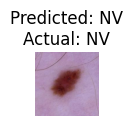

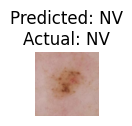

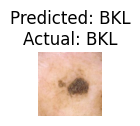

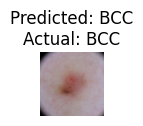

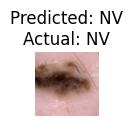

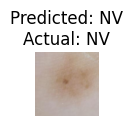

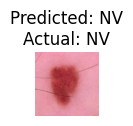

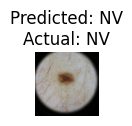

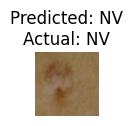

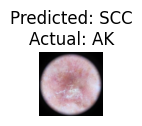

In [ ]:
visualize_model(model_ft, num_images=10)

In [ ]:
# New parameterized function for softmax uncertainty
def softmax_uncertainty_func(x):
    return 1 - torch.max(F.softmax(x, dim=0)).item()

# New parameterized function for random uncertainty
def random_uncertainty_func(x):
    return 1 - torch.rand(1).item()

# Dictionary for uncertainty functions and labels
uncertainty_functions = {
    'softmax': softmax_uncertainty_func,
    'random': random_uncertainty_func,
}

In [ ]:
# Lists to store results
risks_list_regular = []
risks_list_oversampled = []
labels_list_regular = []
labels_list_oversampled = []

In [ ]:
def calculate_softmax_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Compute uncertainty based on softmax probabilities
            for idx in range(len(predicted)):
                predicted_class = predicted[idx].item()
                uncertainty = 1.0 - probabilities[idx, predicted_class].item()  # Using confidence as uncertainty
                uncertainties.append(uncertainty)

    return guesses_are_correct, uncertainties

In [ ]:
def calculate_random_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Generate a single random uncertainty value for each predicted class
            for idx in range(len(predicted)):
                uncertainty = random.random()
                uncertainties.append(uncertainty)

    return guesses_are_correct, uncertainties

In [ ]:
def calculate_mc_dropout_uncertainties(model, dataloader, class_names, device, num_samples=100):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)

            # Monte Carlo Dropout: Perform multiple forward passes with dropout enabled
            predictions = torch.zeros((num_samples, inputs.size(0), len(class_names)), device=device)
            for i in range(num_samples):
                model.train()
                outputs = model(inputs)
                predictions[i] = F.softmax(outputs, dim=1)

            # Calculate mean and variance across predictions
            mean_predictions = torch.mean(predictions, dim=0)
            var_predictions = torch.var(predictions, dim=0)

            # Compute uncertainty using variance across predictions
            uncertainties.extend(var_predictions.cpu().numpy())

            # Determine correctness of predictions
            _, predicted = torch.max(mean_predictions, 1)
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

    return guesses_are_correct, uncertainties

In [ ]:
# Combined function for uncertainty calculation
def calculate_uncertainties_combined(model, dataloader, uncertainty_func, use_mc_dropout, num_mc_samples, class_names, device):
    # Lists to store correctness of predictions and uncertainties
    guesses_are_correct = []
    uncertainties = []

    # Save the original training mode of the model
    was_training = model.training
    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Iterate over the batches in the dataloader
        for i, (inputs, labels) in enumerate(dataloader):
            # Move inputs and labels to the specified device (GPU or CPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            if use_mc_dropout:
                # If using MC dropout, perform multiple forward passes with dropout enabled
                mc_outputs = torch.zeros((num_mc_samples, inputs.size(0), len(class_names)), device=device)

                for mc_sample in range(num_mc_samples):
                    # Enable dropout during training
                    model.train()
                    # Forward pass to get model outputs
                    outputs = model(inputs)
                    # Save the output for the current MC dropout sample
                    mc_outputs[mc_sample] = outputs

                # Disable dropout during evaluation
                model.eval()

                # Calculate uncertainty for each input
                for j in range(len(inputs)):
                    try:
                        uncertainties.append(uncertainty_func(mc_outputs[:, j, :]))
                    except IndexError as e:
                        print(f"IndexError occurred: {e}. Skipping the current iteration.")
                        continue

                # Calculate mean probabilities over all MC dropout samples
                mean_probs = torch.mean(mc_outputs, dim=0)
                # Get the predicted class with the maximum mean probability
                _, preds = torch.max(mean_probs, 1)
            else:
                # If not using MC dropout, perform a single forward pass
                outputs = model(inputs)

                # Calculate uncertainty for each input
                for j in range(len(inputs)):
                    try:
                        uncertainties.append(uncertainty_func(outputs[j]))
                    except IndexError as e:
                        print(f"IndexError occurred: {e}. Skipping the current iteration.")
                        continue

                # Get the predicted class with the maximum output probability
                _, preds = torch.max(outputs, 1)

            # Check correctness of predictions and store the result
            for j in range(len(inputs)):
                try:
                    predicted_class = class_names[preds[j]]
                    actual_class = class_names[labels[j]]
                    guesses_are_correct.append(actual_class == predicted_class)
                except IndexError as e:
                    print(f"IndexError occurred: {e}. Skipping the current iteration.")
                    continue

    # Restore the original training mode of the model
    model.train(mode=was_training)

    # Return correctness of predictions and uncertainties
    return guesses_are_correct, uncertainties

In [ ]:
def calculate_risks(guesses_are_correct, uncertainties):
    risks = []

    while uncertainties:
        risk = 1 - (sum(guesses_are_correct) / len(guesses_are_correct))
        risks.append(risk)

        max_uncertainty_index = uncertainties.index(max(uncertainties))
        uncertainties.pop(max_uncertainty_index)
        guesses_are_correct.pop(max_uncertainty_index)

    risks.reverse()

    return risks

In [ ]:
def run_uncertainties_for_dataloader(model, dataloader_type, num_mc_samples, class_names, device):
    dataloader = dataloaders[dataloader_type]

    for uncertainty_type, uncertainty_func in uncertainty_functions.items():
        # Without MC Dropout
        guesses_are_correct, uncertainties = calculate_uncertainties_combined(
            model,
            dataloader,
            uncertainty_func,
            False,  # No MC dropout
            1,  # num_mc_samples (not used in this case, so any value will work)
            class_names,
            device
        )

        risks = calculate_risks(guesses_are_correct, uncertainties)
        if dataloader_type == 'val':
            risks_list_regular.append(risks)
            labels_list_regular.append(f'{uncertainty_type.capitalize()} Risks (No MC Dropout) - {dataloader_type.capitalize()}')
        elif dataloader_type == 'val_oversampled':
            risks_list_oversampled.append(risks)
            labels_list_oversampled.append(f'{uncertainty_type.capitalize()} Risks (No MC Dropout) - {dataloader_type.capitalize()}')

        # With MC Dropout
        guesses_are_correct, uncertainties = calculate_uncertainties_combined(
            model,
            dataloader,
            uncertainty_func,
            True,  # With MC dropout
            10,   # num_mc_samples
            class_names,
            device
        )

        risks = calculate_risks(guesses_are_correct, uncertainties)
        if dataloader_type == 'val':
            risks_list_regular.append(risks)
            labels_list_regular.append(f'{uncertainty_type.capitalize()} Risks (With MC Dropout) - {dataloader_type.capitalize()}')
        elif dataloader_type == 'val_oversampled':
            risks_list_oversampled.append(risks)
            labels_list_oversampled.append(f'{uncertainty_type.capitalize()} Risks (With MC Dropout) - {dataloader_type.capitalize()}')


In [ ]:
# Run uncertainties for the original validation set
run_uncertainties_for_dataloader(model_ft, 'val', 10, class_names, device)

# Run uncertainties for the oversampled validation set
run_uncertainties_for_dataloader(model_ft, 'val_oversampled', 10, class_names, device)

In [ ]:
# Interpolate the data for smoother curves
x_values_regular = np.arange(len(risks_list_regular[0]))
x_values_oversampled = np.arange(len(risks_list_oversampled[0]))
total_steps_regular = len(x_values_regular)
total_steps_oversampled = len(x_values_oversampled)

# Convert x-values to percentage
x_smooth_percentage_regular = (x_values_regular / total_steps_regular) * 100
x_smooth_percentage_oversampled = (x_values_oversampled / total_steps_oversampled) * 100

# Create a smooth range for the x-axis
x_smooth_percentage_interp_regular = np.linspace(x_smooth_percentage_regular.min(), x_smooth_percentage_regular.max(), 300)
x_smooth_percentage_interp_oversampled = np.linspace(x_smooth_percentage_oversampled.min(), x_smooth_percentage_oversampled.max(), 300)

In [ ]:
# Plotting the results with smooth curves
def plot_risks_combined(risks_list, labels_list, x_smooth_percentage_interp, x_smooth_percentage):
    for risks, label in zip(risks_list, labels_list):
        risks_smooth = np.interp(x_smooth_percentage_interp, x_smooth_percentage, risks)
        plt.plot(x_smooth_percentage_interp, risks_smooth, label=label, linewidth=1)

    # x-axis label with a percentage
    plt.xlabel('Coverage (%)')
    plt.ylabel('Risk')
    plt.title('Risk vs. Coverage')

    # Adjust the y-axis limits
    plt.ylim(0, 1)

    # Invert the x-axis
    plt.gca().invert_xaxis()

    # Show legend
    plt.legend()

    plt.show()

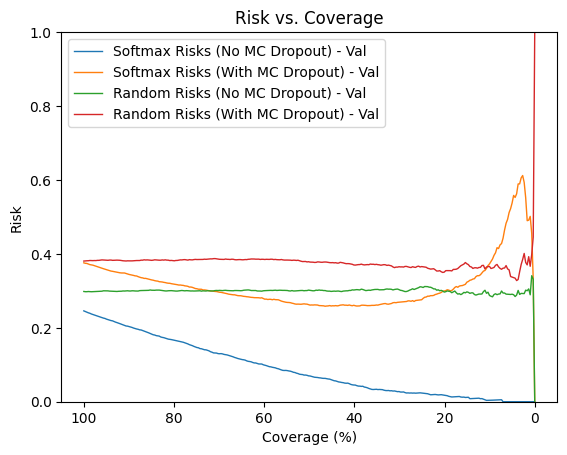

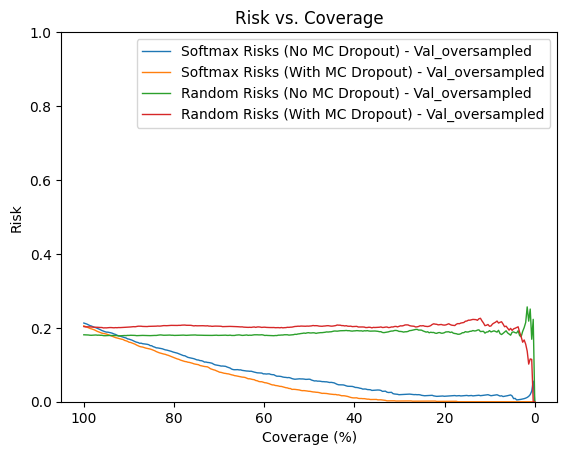

In [ ]:
# Plotting the results with smooth curves for the regular dataloader
plot_risks_combined(risks_list_regular, labels_list_regular, x_smooth_percentage_interp_regular, x_smooth_percentage_regular)

# Plotting the results with smooth curves for the oversampled dataloader
plot_risks_combined(risks_list_oversampled, labels_list_oversampled, x_smooth_percentage_interp_oversampled, x_smooth_percentage_oversampled)

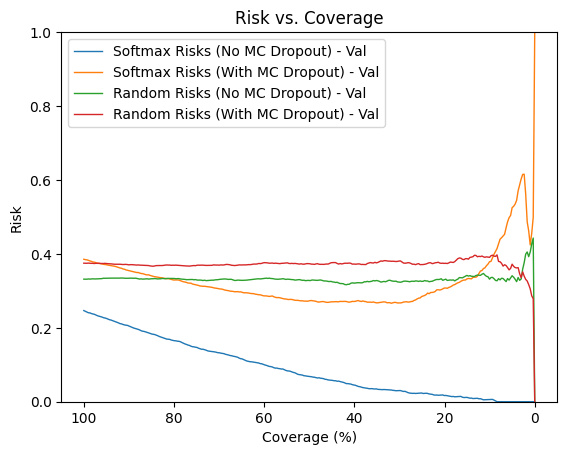

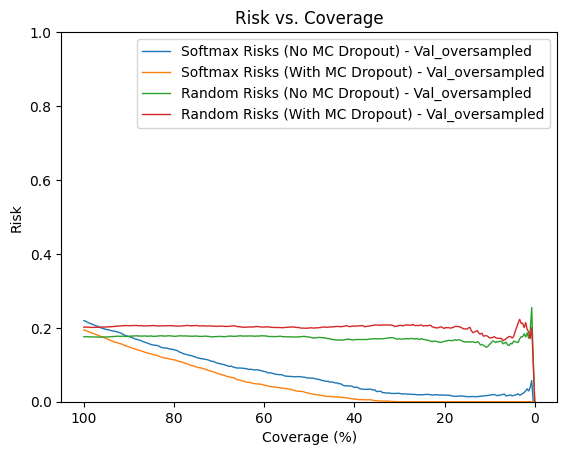

In [ ]:
# Lists to store results
risks_list_regular = []
risks_list_oversampled = []
labels_list_regular = []
labels_list_oversampled = []

# Run uncertainties for the original validation set
run_uncertainties_for_dataloader(model_ft, 'val', 50, class_names, device)

# Run uncertainties for the oversampled validation set
run_uncertainties_for_dataloader(model_ft, 'val_oversampled', 50, class_names, device)

# Interpolate the data for smoother curves
x_values_regular = np.arange(len(risks_list_regular[0]))
x_values_oversampled = np.arange(len(risks_list_oversampled[0]))
total_steps_regular = len(x_values_regular)
total_steps_oversampled = len(x_values_oversampled)

# Convert x-values to percentage
x_smooth_percentage_regular = (x_values_regular / total_steps_regular) * 100
x_smooth_percentage_oversampled = (x_values_oversampled / total_steps_oversampled) * 100

# Create a smooth range for the x-axis
x_smooth_percentage_interp_regular = np.linspace(x_smooth_percentage_regular.min(), x_smooth_percentage_regular.max(), 300)
x_smooth_percentage_interp_oversampled = np.linspace(x_smooth_percentage_oversampled.min(), x_smooth_percentage_oversampled.max(), 300)

# Plotting the results with smooth curves for the regular dataloader
plot_risks_combined(risks_list_regular, labels_list_regular, x_smooth_percentage_interp_regular, x_smooth_percentage_regular)

# Plotting the results with smooth curves for the oversampled dataloader
plot_risks_combined(risks_list_oversampled, labels_list_oversampled, x_smooth_percentage_interp_oversampled, x_smooth_percentage_oversampled)

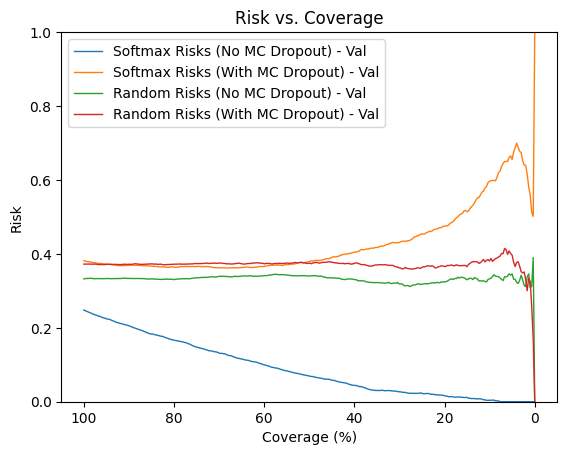

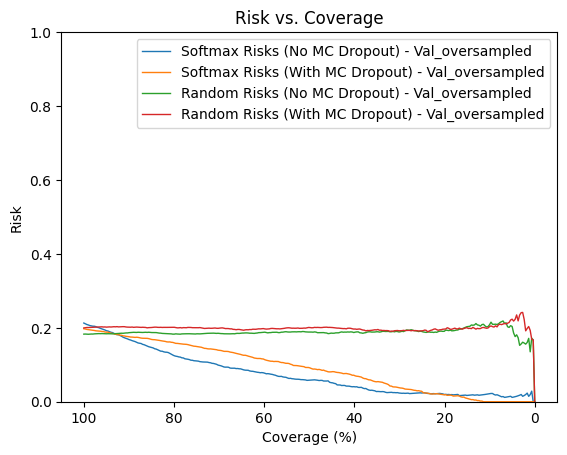

In [ ]:
# Lists to store results
risks_list_regular = []
risks_list_oversampled = []
labels_list_regular = []
labels_list_oversampled = []

# Run uncertainties for the original validation set
run_uncertainties_for_dataloader(model_ft, 'val', 10, class_names, device)

# Run uncertainties for the oversampled validation set
run_uncertainties_for_dataloader(model_ft, 'val_oversampled', 10, class_names, device)

# Interpolate the data for smoother curves
x_values_regular = np.arange(len(risks_list_regular[0]))
x_values_oversampled = np.arange(len(risks_list_oversampled[0]))
total_steps_regular = len(x_values_regular)
total_steps_oversampled = len(x_values_oversampled)

# Convert x-values to percentage
x_smooth_percentage_regular = (x_values_regular / total_steps_regular) * 100
x_smooth_percentage_oversampled = (x_values_oversampled / total_steps_oversampled) * 100

# Create a smooth range for the x-axis
x_smooth_percentage_interp_regular = np.linspace(x_smooth_percentage_regular.min(), x_smooth_percentage_regular.max(), 300)
x_smooth_percentage_interp_oversampled = np.linspace(x_smooth_percentage_oversampled.min(), x_smooth_percentage_oversampled.max(), 300)

# Plotting the results with smooth curves for the regular dataloader
plot_risks_combined(risks_list_regular, labels_list_regular, x_smooth_percentage_interp_regular, x_smooth_percentage_regular)

# Plotting the results with smooth curves for the oversampled dataloader
plot_risks_combined(risks_list_oversampled, labels_list_oversampled, x_smooth_percentage_interp_oversampled, x_smooth_percentage_oversampled)